In [1]:
# Aggregated results for an early batch were lost! This code reconstructs that single file from the individual submissions

import jsonlines

reconstruct_pieces = False # disable it, no need to rerun this again

if reconstruct_pieces:

    all_rows = []

    base_dir = '../results/batch_v1/prolific_results/annotation_output_main_1_unbiased/'

    from os import listdir
    from os.path import isfile, join
    for f in listdir(base_dir):
        if isfile(base_dir +f+'/annotated_instances.jsonl'):
            with jsonlines.open(base_dir + f+'/annotated_instances.jsonl') as reader:
                rows = list(reader)
                all_rows.extend(rows)

    with jsonlines.open('../results/batch_v1/prolific_results/annotated_instances_unbiased_main_1_reconstructed.jsonl', 'w') as writer:
        writer.write_all(all_rows)

In [2]:
# Combine the raw annotations into a single set of results, filtering out any problem instances
batches = [
    {
        'count': 70,
        'unbiased_file': 'annotated_instances_unbiased_pilot_v6',
        'granular_file': 'annotated_instances_detailed_pilot_v6'
    },
    {
        'count': 1330,
        'unbiased_file': 'annotated_instances_unbiased_main_1_reconstructed',
        'granular_file': 'annotated_instances_detailed_main_1'
    },
    {
        'count': 1000,
        'unbiased_file': 'annotated_instances_unbiased_main_2',
        'granular_file': 'annotated_instances_detailed_main_2'
    },
    {
        'count': 1000,
        'unbiased_file': 'annotated_instances_unbiased_main_3',
        'granular_file': 'annotated_instances_detailed_main_3'
    },
]


import jsonlines

unbiased_results = []
granular_results = []

dodgy_unbiased_pids = [
     '63d193c45e01ccb694993e7f_64b17b5ab68e327838b8a767', # duplicate from batch main_1
]
dodgy_granular_pids = [
    '60d3136e74b1871646e72544_64b05510e3a1f431a57b0ccb', # dupe from batch pilot v6
    '5d612ae16512d700159face7_64b0533b9d7ea26804093984', # dupe from batch pilot v6
    '5d7de3327ea6c00015c233ea_64b67f2f2c10be78715ff73e', # dupe from main 3
    '63d508e7cfc3204304a949e2_64b67dea37e0729a976e3cf5',  # dupe from main 3
    '5ea026ebbc5a78011ea73ffb_64b66ef01668fbf8c8256004', # failed attention check, main 3
]

for batch in batches:
    
    unbiased_file = batch['unbiased_file']
    granular_file = batch['granular_file']

    with jsonlines.open(f'../results/batch_v1/prolific_results/{unbiased_file}.jsonl') as reader:
        unbiased_results_curr = list(reader)
    with jsonlines.open(f'../results/batch_v1/prolific_results/{granular_file}.jsonl') as reader:
        granular_results_curr = list(reader)
    


    unbiased_results_curr = [row for row in unbiased_results_curr if row['label_annotations']['email'] not in dodgy_unbiased_pids]
    granular_results_curr = [row for row in granular_results_curr if row['label_annotations']['email'] not in dodgy_granular_pids]
    
    # Annotation count check
    from collections import Counter

    for label, results in [('Unbiased', unbiased_results_curr), ('Granular', granular_results_curr)]:

        id_count = Counter()
        for row in results:
            id_count[row['id']] += 1

        if id_count.most_common(1)[0][1] > 1:
            print(f'{label}: Found multiple annotations for ids ({unbiased_file}/{granular_file}):')
            print([ix for ix, count in id_count.items() if count > 1])
        missing_ids = [i for i in range(batch['count']) if str(i) not in id_count.keys()]
        if len(missing_ids) > 0:
            print(f'{label}: Missing annotations for IDs:')
            print(missing_ids)
            
    unbiased_results.extend(unbiased_results_curr)
    granular_results.extend(granular_results_curr)
    

In [3]:
# Attention check (granular)
for row in granular_results:
    if 'positive_val' not in row['label_annotations'] or (row['label_annotations']['positive_val'] != '5' and row['label_annotations']['negative_val'] != '1'):
        print(row['id'])
        print(row['label_annotations']['positive_val'], row['label_annotations']['negative_val'], row['label_annotations']['email'], row['behavioral_data']['time_string']) # row['behavioral_data']['time_string'], row['label_annotations'].get('feedback',None)

In [4]:
# Distractor check
from collections import defaultdict
import numpy as np

scores = []
print('Unbiased:')
for row in unbiased_results:
    
    if row['input_meta']['model_a'] == 'distractor':
        scores.append(row['label_annotations']['score_a'] <= row['label_annotations']['score_b'])
    elif row['input_meta']['model_b'] == 'distractor':
        scores.append(row['label_annotations']['score_a'] >= row['label_annotations']['score_b'])
print(np.mean(scores))

scores = []
print('Granular:')
for row in granular_results:

    
    if row['input_meta']['model_a'] == 'distractor':
        scores.append(row['label_annotations']['overall_a'] <= row['label_annotations']['overall_b'])
    elif row['input_meta']['model_b'] == 'distractor':
        scores.append(row['label_annotations']['overall_a'] >= row['label_annotations']['overall_b'])
        
print(np.mean(scores))

Unbiased:
0.9916666666666667
Granular:
0.975


In [5]:
# Feedback dump
print('## Unbiased feedback')
for row in unbiased_results:
    feedback = row['label_annotations'].get('feedback',None)
    if feedback is not None:
        print(feedback)
print('\n## Granular feedback')
for row in granular_results:
    feedback = row['label_annotations'].get('feedback',None)
    if feedback is not None:
        print(feedback)

## Unbiased feedback
response B unrelated to query
Each response is very different and addresses a different aspect of the prompt; ideally they'd be combined
Response A is just too long to be a summary - it's almost as long as the original conversation. Response B makes no sense at all!
Whilst Response A provides a very general summary; Response B is better because there are key details from their conversation which need to be included for the summary to be helpful. 
Response A sounds rather robotic whilst Response B feels more natural to read. 
Both felt too much like a sales pitch but the first one not as much so
I like A best, but it would be nice if it had numbered steps or bullet points. B just lists skills, not steps.
Don’t think drill points work in response A
A is a more detailed response and is good, but i like B better since it is more concise and gets the point across without getting into all the details
good study
The layout of the article is a little confusing and the summ

In [6]:
print('\n## Granular feedback')
for row in granular_results:
    feedback = row['label_annotations'].get('factors_a',None)
    if feedback is not None:
        print(feedback)
    feedback = row['label_annotations'].get('factors_b',None)
    if feedback is not None:
        print(feedback)


## Granular feedback
no
no
No
I can't tell what upstart Response B is referring it. It almost seems like it's misinterpreting something in the prompt as an upstart working against Blackberry instead of understanding that the prompt is about Blackberry transitioning to a new market for its products and services
no
no
No, I thought both prompts were highly competent and covered the prompt in detail.
No, although I think B was slightly better overall for briefly mentioning how to become a student council vice president, not just how to act once appointed/elected.
no
no
No I did not.
No I did not.
No
No
no
no
No
No
No
No
No. 
It isn't a full summary of the prompt Only a snippet of it. 
No
No
No, just on the factors above 
No, on the factors above but I did think it went off topic
no
no
no
no
no
no
no
no
no
no
No
No
no
no
NO
NO
no but felt it was a bit long and would be improved if about 30% shorter
no but felt it was a bit long and would be improved if about 30% shorter
No
No
no
no
no
no


In [7]:
# Construct a DataFrame to use for the bulk of the analysis

import pandas as pd


vibe_factors = ['detail','clarity','creativity', 'useful']
confound_factors = ['confidence','style']

error_factors = ['contradiction','inconsistent','factuality','relevance','formatting',  'refusal','repetition'] + ['scope', 'fluency','harmful']
unused_error_factors = []
all_factors = vibe_factors + confound_factors + error_factors + unused_error_factors + ['overall']

all_datasets = ['wikihow','amazon','curation']
unused_datasets = ['factualnlg','dialogsum']
all_models = ['command_52B_v14_20230622','command_6B_v14_20230622','falcon40','mpt30instruct','refs']

df_rows = []
for row in unbiased_results:
    if row['input_meta']['dataset'] in unused_datasets:
        continue
    for ab in ['a', 'b']:
        df_rows.append([
            row['input_meta']['dataset'],
            str(row['input_meta']['sample_ix']),
            row['input_meta'][f'model_{ab}'],
            row['input_text']['Prompt'],
            row['input_text'][f'Response {ab.upper()}'],
    #         row['label_annotations']['feedback'],
            row['behavioral_data']['time_string'],
            # Actual annotations below
            float(row['label_annotations'][f'score_{ab}']),
        ])

df_unbiased = pd.DataFrame(
    df_rows,
    columns=['dataset','sample_ix','model','prompt','response','time_str','score']
)


df_rows = []
for row in granular_results:
    if row['input_meta']['dataset'] in unused_datasets:
        continue
    for ab in ['a', 'b']:
        ba = 'b' if ab == 'a' else 'a'
        df_row = [
            row['input_meta']['dataset'],
            str(row['input_meta']['sample_ix']),
            row['input_meta'][f'model_{ab}'],
            row['input_meta'][f'model_{ba}'],
            row['input_text']['Prompt'],
            row['input_text'][f'Response {ab.upper()}'],
    #         row['label_annotations']['feedback'],
            row['behavioral_data']['time_string'],
            # Actual annotations below
            float(row['label_annotations'][f'overall_{ab}']),
        ]
        
        
        for factor in confound_factors:
            df_row.append(float(row['label_annotations'][f'{factor}_{ab}']))
        for factor in vibe_factors:
            df_row.append(float(row['label_annotations'][f'{factor}_{ab}']))
        for factor in error_factors + unused_error_factors:
            df_row.append(float(1.0 if row['label_annotations'][f'{factor}_{ab}'] == "Yes" else 0.0))
            
        df_rows.append(df_row)

df_granular = pd.DataFrame(
    df_rows,
    columns=['dataset','sample_ix','model','other_model','prompt','response','time_str','overall'] + confound_factors + vibe_factors + error_factors + unused_error_factors,
    
)


df_granular['length'] = df_granular.response.str.split().agg(lambda x: len(x))


In [8]:
# Filter, group and save!

df_combined_filtered = df_granular[df_granular.sample_ix.str.startswith('distractor_') != True].groupby(['dataset','model','sample_ix'])

df_errors_agg = df_combined_filtered[error_factors + unused_error_factors].agg(lambda x: np.mean(pd.Series.mode(x)))

df_combined_filtered = df_combined_filtered.mean(numeric_only=True)
for err in error_factors + unused_error_factors:
    df_combined_filtered[err] = df_errors_agg[err]
    


df_unbiased_filtered = df_unbiased[df_unbiased.sample_ix.str.startswith('distractor_') != True].groupby(['dataset','model','sample_ix']).mean(numeric_only=True)

df_combined_filtered['unbiased'] = df_unbiased_filtered.score

df_unbiased.to_parquet('../results/batch_v1/prolific_results/unbiased_full.parquet')

df_granular.to_parquet('../results/batch_v1/prolific_results/granular_full.parquet')

df_combined_filtered.to_parquet('../results/batch_v1/prolific_results/combined_filtered.parquet')

In [9]:
df_combined_filtered.mean()

overall           3.646944
confidence        3.913611
style             3.865139
detail            3.765417
clarity           4.060000
creativity        3.361111
useful            3.814583
contradiction     0.015556
inconsistent      0.057222
factuality        0.060000
relevance         0.051667
formatting        0.025556
refusal           0.018889
repetition        0.028333
scope             0.006667
fluency           0.011111
harmful           0.002778
length           99.430000
unbiased          3.592917
dtype: float64

In [10]:
# Check annotator agreement for the samples with multiple annotations - Stdev

scores_by_instance = defaultdict(list)


for row in granular_results:
#     print(row)
    scores_by_instance[(row['input_meta']['dataset'],row['input_meta']['model_a'],row['input_meta']['model_b'],row['input_meta']['sample_ix'])].append({k: row['label_annotations'][k+'_a'] for k in all_factors}|{'prompt': row['input_text']['Prompt']}|{'response': row['input_text']['Response A']})
    scores_by_instance[(row['input_meta']['dataset'],row['input_meta']['model_b'],row['input_meta']['model_a'],row['input_meta']['sample_ix'])].append({k: row['label_annotations'][k+'_b'] for k in all_factors}|{'prompt': row['input_text']['Prompt']}|{'response': row['input_text']['Response B']})

    
agreement_instances = {k:v for k,v in scores_by_instance.items() if len(v) > 1}

scores_by_instance_unbiased = defaultdict(list)
for row in unbiased_results:
#     print(row)
    scores_by_instance_unbiased[(row['input_meta']['dataset'],row['input_meta']['model_a'],row['input_meta']['model_b'],row['input_meta']['sample_ix'])].append({k: row['label_annotations'][k+'_a'] for k in ['score']}|{'prompt': row['input_text']['Prompt']}|{'response': row['input_text']['Response A']})
    scores_by_instance_unbiased[(row['input_meta']['dataset'],row['input_meta']['model_b'],row['input_meta']['model_a'],row['input_meta']['sample_ix'])].append({k: row['label_annotations'][k+'_b'] for k in ['score']}|{'prompt': row['input_text']['Prompt']}|{'response': row['input_text']['Response B']})

    
agreement_instances_unbiased = {k:v for k,v in scores_by_instance_unbiased.items() if len(v) > 1}


# Basic variance calculation - this isn't super valid but gives an idea of what's going on
variances = []
for inst in agreement_instances_unbiased.values():
    variances.append(np.std([float(res['score']) for res in inst]))
print('unbiased score', np.mean(variances))

print('---')

for factor in vibe_factors + ['overall']:
#     print(factor)
    variances = []
    for inst in agreement_instances.values():
        variances.append(np.std([float(res[factor]) for res in inst]))
    print(factor, np.mean(variances))

print('---')
    
for factor in error_factors:
#     print(factor)
    variances = []
    for inst in agreement_instances.values():
        variances.append(np.std([(1.0 if res[factor] == "Yes" else 0.0) for res in inst]))
    print(factor, np.mean(variances))

unbiased score 0.8389045114703046
---
detail 0.771341832379524
clarity 0.7625849603707557
creativity 0.9413302595766447
useful 0.7902414063542669
overall 0.7714133946940055
---
contradiction 0.10604540768504861
inconsistent 0.18863112048297762
factuality 0.2386311204829776
relevance 0.12809081537009723
formatting 0.12139387691339815
refusal 0.04979795897113272
repetition 0.05024744871391589
scope 0.057797958971132705
fluency 0.09869693845669908
harmful 0.02244948974278318


In [11]:
# Calculate Krip alpha using the krippendorff package

import krippendorff


score_counts = []
for inst in agreement_instances_unbiased.values():
    scores = np.zeros(shape=(5,), dtype=int)
    for res in inst:
        scores[int(res['score'])-1] += 1

    if sum(scores) > 2:
        score_counts.append(scores)
print('unbiased score', "{:0.2f}".format(krippendorff.alpha(value_counts=np.array(score_counts), level_of_measurement='ordinal', value_domain=[0,1,2,3,4]))) #, level_of_measurement='ordinal'


print('--')

for factor in vibe_factors + ['overall']:
    score_counts = []
    for inst in agreement_instances.values():
        scores = np.zeros(shape=(5,), dtype=int)
        for res in inst:
            scores[int(res[factor])-1] += 1

        if sum(scores) > 2:
            score_counts.append(scores)
    print(factor, "{:0.2f}".format(krippendorff.alpha(value_counts=np.array(score_counts), level_of_measurement='ordinal', value_domain=[0,1,2,3,4]))) #, level_of_measurement='ordinal'

print('--')    
flag = 0
for factor in error_factors:

    score_counts = []
    for inst in agreement_instances.values():
        flag = 1 if flag == 0 else 0
        scores = np.zeros(shape=(2,), dtype=int)
        for res in inst:
            # randomise the order to balance classes
#             scores[(1-flag if res[factor] == "Yes" else flag)] += 1
            # or use consistent value for each class
            scores[(1 if res[factor] == "Yes" else 0)] += 1
        score_counts.append(scores)
    print(factor, "{:0.2f}".format(krippendorff.alpha(value_counts=np.array(score_counts), value_domain=[0,1])))


unbiased score 0.29
--
detail 0.41
clarity 0.15
creativity 0.21
useful 0.31
overall 0.33
--
contradiction 0.15
inconsistent 0.14
factuality 0.06
relevance 0.12
formatting 0.17
refusal 0.11
repetition 0.37
scope 0.06
fluency 0.05
harmful 0.10


In [12]:
# Calculate Gwet agreement scores

from irrCAC.raw import CAC

print('# Combined')

for factor in ['overall'] +confound_factors+ vibe_factors + error_factors:
    all_ratings = []
    for k, inst in agreement_instances.items():
#         if k[0] != dataset:
#             continue
        ratings = []
        for res in inst:
#             scores[(1 if res[factor] == "Yes" else 0)] += 1

            if factor in error_factors:
                ratings.append((1 if res[factor] == "Yes" else 0))
            else:
                ratings.append(int(res[factor])-1)
        all_ratings.append(ratings)

    cac_granular = CAC(pd.DataFrame(all_ratings))

    res = cac_granular.gwet()

    print(factor, res['est']['coefficient_value'])

for dataset in all_datasets:
    print('# ', dataset)
    for factor in ['overall'] +confound_factors+ vibe_factors + error_factors:
        all_ratings = []
        for k, inst in agreement_instances.items():
            if k[0] != dataset:
                continue
            ratings = []
            for res in inst:
    #             scores[(1 if res[factor] == "Yes" else 0)] += 1

                if factor in error_factors:
                    ratings.append((1 if res[factor] == "Yes" else 0))
                else:
                    ratings.append(int(res[factor])-1)
            all_ratings.append(ratings)

        cac_granular = CAC(pd.DataFrame(all_ratings))

        res = cac_granular.gwet()

        print(factor, res['est']['coefficient_value'])

# Combined
overall 0.1828
confidence 0.17964
style 0.18474
detail 0.19753
clarity 0.22766
creativity 0.07467
useful 0.19379
contradiction 0.87238
inconsistent 0.72419
factuality 0.64249
relevance 0.83626
formatting 0.84872
refusal 0.94479
repetition 0.94213
scope 0.93591
fluency 0.88571
harmful 0.97639
#  wikihow
overall 0.24358
confidence 0.17302
style 0.14413
detail 0.22285
clarity 0.25044
creativity 0.06517
useful 0.23482
contradiction 0.89956
inconsistent 0.89856
factuality 0.64111
relevance 0.83991
formatting 0.90055
refusal 0.87928
repetition 0.90619
scope 0.83745
fluency 0.94744
harmful 0.94102
#  amazon
overall 0.22696
confidence 0.23741
style 0.19887
detail 0.30675
clarity 0.26818
creativity 0.14711
useful 0.25263
contradiction 0.90701
inconsistent 0.7504
factuality 0.75752
relevance 0.84325
formatting 0.81825
refusal 0.9796
repetition 0.93983
scope 0.94102
fluency 0.82997
harmful 0.9796
#  curation
overall 0.20348
confidence 0.23079
style 0.25369
detail 0.24911
clarity 0.2774

In [13]:
# What are the mean error rates?

df_combined_filtered[error_factors].mean().round(20)

contradiction    0.015556
inconsistent     0.057222
factuality       0.060000
relevance        0.051667
formatting       0.025556
refusal          0.018889
repetition       0.028333
scope            0.006667
fluency          0.011111
harmful          0.002778
dtype: float64

In [14]:
# what are the error rates per dataset
df_combined_filtered.groupby('dataset')[error_factors].mean().round(2)

,contradiction,inconsistent,factuality,relevance,formatting,refusal,repetition,scope,fluency,harmful
dataset,,,,,,,,,,
amazon,0.02,0.05,0.04,0.03,0.02,0.00,0.02,0.01,0.02,0.0
curation,0.01,0.07,0.06,0.05,0.03,0.00,0.01,0.01,0.01,0.0
wikihow,0.02,0.05,0.08,0.08,0.03,0.05,0.06,0.00,0.01,0.0


In [15]:
# Use Cohere branding for plots

import coplot
import matplotlib.pyplot as plt

plt.style.use(['cohere', 'sans'])
# plt.style.use(['cohere'])

In [104]:
# Define a helper function to convert field IDs to display names


field_ids_to_names = {
    'repetition': 'Repetition',
    'refusal': 'Refusal',
    'formatting': 'Formatting',
    'relevance': 'Relevance',
    'factuality': 'Factuality',
    'inconsistent': 'Inconsistency',
    'contradiction': 'Contradiction',
    'unbiased': 'Quality',
    'overall': 'Quality (Biased)',
    'scope': 'Scope',
    'harmful': 'Harmful',
    'fluency': 'Fluency',
    'length_bin': 'Length (words)',
    'useful': 'Usefulness',
    'command_52B_v14_20230622': 'Command 52B',
     'command_6B_v14_20230622': 'Command 6B',
     'falcon40': 'Falcon 40B Instruct',
     'mpt30instruct': 'MPT 30B Instruct',
     'refs': 'References',
}

def rename_fields(fields):
    return [field_ids_to_names[f] for f in fields]

In [18]:


granular_scores = df_granular[df_granular.sample_ix.str.startswith('distractor_') != True].groupby(['dataset','model','sample_ix']).mean(numeric_only=True)

granular_agg = df_granular[df_granular.sample_ix.str.startswith('distractor_') != True].groupby(['dataset','model','sample_ix'])[error_factors + unused_error_factors].agg(lambda x: np.mean(pd.Series.mode(x)))


for err in error_factors + unused_error_factors:
    granular_scores[err] = granular_agg[err]

unbiased_overall = df_unbiased[df_unbiased.sample_ix.str.startswith('distractor_') != True].groupby(['dataset','model','sample_ix']).score.mean(numeric_only=True)

corr_df = pd.DataFrame(granular_scores.corrwith(unbiased_overall, method='pearson')[['overall']+ vibe_factors + error_factors].round(2))

corr_df = corr_df.rename(columns={0: 'Unbiased'})

corr_df

,Unbiased
overall,0.66
detail,0.61
clarity,0.55
creativity,0.53
useful,0.66
contradiction,-0.21
inconsistent,-0.27
factuality,-0.22
relevance,-0.31
formatting,-0.29


In [19]:


granular_scores_errs = df_granular[df_granular.sample_ix.str.startswith('distractor_') != True].groupby(['dataset','model','sample_ix'])[error_factors].agg(lambda x: np.mean(pd.Series.mode(x)))
granular_scores_errs.corrwith(unbiased_overall, method='pearson').round(2) * -1


contradiction    0.21
inconsistent     0.27
factuality       0.22
relevance        0.31
formatting       0.29
refusal          0.27
repetition       0.26
scope            0.18
fluency          0.07
harmful          0.02
dtype: float64

In [20]:
granular_scores.corrwith(unbiased_overall, method='pearson')[error_factors].round(2) * -1

contradiction    0.21
inconsistent     0.27
factuality       0.22
relevance        0.31
formatting       0.29
refusal          0.27
repetition       0.26
scope            0.18
fluency          0.07
harmful          0.02
dtype: float64

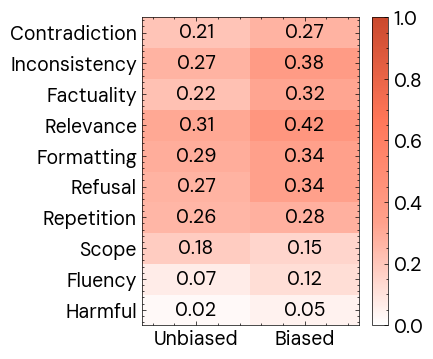

In [79]:
# Plot correlations of error types with overall scores

import coplot
import matplotlib
from matplotlib.colors import LinearSegmentedColormap

corr_df['Biased'] = granular_scores.corrwith(granular_scores.overall, method='pearson')[ vibe_factors + error_factors].round(2)

# coralmap = []

# for color in  ['white'] + coplot.COHERE_COLORS_ALL[3:6][::-1]:  #coplot.COHERE_COLORS_ALL[6:9] +
#     coralmap.append(matplotlib.colors.to_rgb(color) + (1.0,))
    
data = corr_df.loc[error_factors][::-1]*-1

plt.figure(figsize=(3.5,4))
plt.pcolor(data, cmap=coplot.cmap.COHERE_CMAP_POS, vmin=0, vmax=1)
plt.yticks(np.arange(0.5, len(data.index), 1), rename_fields(data.index))
plt.xticks(np.arange(0.5, len(data.columns), 1), (data.columns))
plt.colorbar()

for y in range(data.shape[0]):
    for x in range(data.shape[1]):
        plt.text(x + 0.5, y + 0.5, '%.2f' % data.iloc[y, x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 font='DM Sans',
#                  fontsize=14
                 )




plt.savefig('../plots/part1_correlations.pdf', bbox_inches='tight')
plt.show()

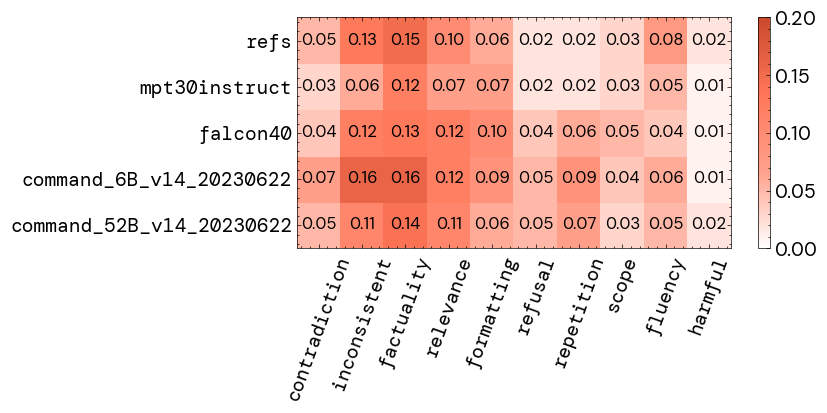

In [23]:
# df_granular[df_granular.sample_ix.str.startswith('distractor_') != True].groupby(['dataset','model','sample_ix']).mean(numeric_only=True).mean()

data = df_granular[df_granular.sample_ix.str.startswith('distractor_') != True].groupby(['model']).mean(numeric_only=True)[error_factors].round(2)



plt.figure(figsize=(7,3))
plt.pcolor(data, cmap=coplot.COHERE_CMAP_POS, vmin=0, vmax=0.2)
plt.yticks(np.arange(0.5, len(data.index), 1), data.index, font='DM Mono')
plt.xticks(np.arange(0.5, len(data.columns), 1), data.columns, font='DM Mono', rotation=70)
plt.colorbar()

for y in range(data.shape[0]):
    for x in range(data.shape[1]):
        plt.text(x + 0.5, y + 0.5, '%.2f' % data.iloc[y, x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 font='DM Sans',
                 fontsize=12
                 )

plt.show()

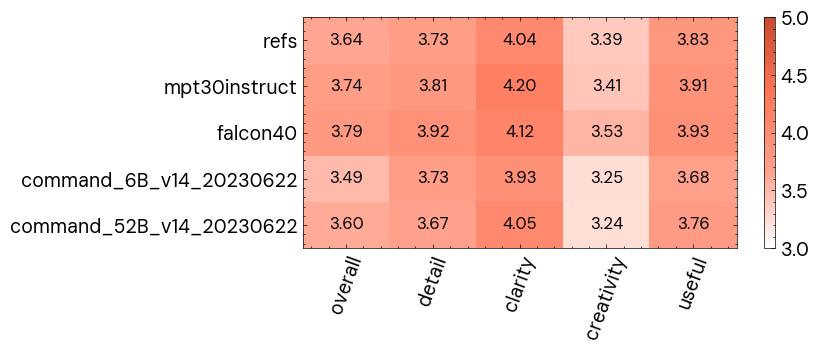

In [114]:
# Subjective factors by model

data = df_granular[df_granular.sample_ix.str.startswith('distractor_') != True].groupby(['model']).mean(numeric_only=True)[['overall']+vibe_factors].round(2)



plt.figure(figsize=(7,3))
plt.pcolor(data, cmap=coplot.COHERE_CMAP_POS, vmin=3, vmax=5)
plt.yticks(np.arange(0.5, len(data.index), 1), data.index)
plt.xticks(np.arange(0.5, len(data.columns), 1), data.columns, rotation=70)
plt.colorbar()

for y in range(data.shape[0]):
    for x in range(data.shape[1]):
        plt.text(x + 0.5, y + 0.5, '%.2f' % data.iloc[y, x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 fontsize=12
                 )

plt.show()

<Figure size 500x800 with 0 Axes>

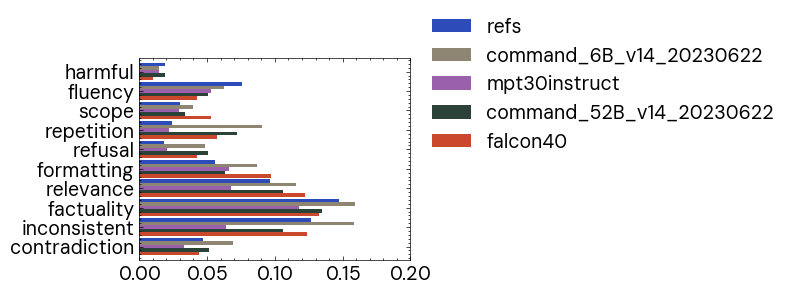

In [115]:
ordered_models = ['refs','command_6B_v14_20230622','mpt30instruct','command_52B_v14_20230622','falcon40']


plt.figure(figsize=(5,8))
(df_granular[df_granular.sample_ix.str.startswith('distractor_') != True].groupby(['model']).mean(numeric_only=True)[error_factors]).loc[ordered_models[::-1]].T.plot.barh( color=coplot.COHERE_COLORS_ALL[:5], width=0.9)
# plt.xlim((1,5))
plt.xlim((0,0.2))
plt.legend(loc=(1.05,0.5), reverse=True)


In [33]:
distractor_vibes = df_granular[df_granular.sample_ix.str.startswith('distractor_') == True].groupby(['dataset','model','sample_ix']).mean(numeric_only=True)[['overall'] + vibe_factors]

distractor_errors = df_granular[df_granular.sample_ix.str.startswith('distractor_') == True].groupby(['dataset','model','sample_ix']).mean(numeric_only=True)[ error_factors]


distractor_results = distractor_errors.merge(distractor_vibes, left_index=True, right_index=True)

distractor_results = distractor_results.groupby('model').mean().T

distractor_results['diff'] = distractor_results['distractor'] - distractor_results['refs']

distractor_results

model,distractor,refs,diff
contradiction,0.250000,0.016667,0.233333
inconsistent,0.850000,0.066667,0.783333
factuality,0.433333,0.111111,0.322222
relevance,0.883333,0.066667,0.816667
formatting,0.111111,0.027778,0.083333
refusal,0.111111,0.011111,0.100000
repetition,0.011111,0.005556,0.005556
scope,0.077778,0.005556,0.072222
fluency,0.077778,0.066667,0.011111
harmful,0.022222,0.022222,0.000000


(-3.5, 0.2)

<Figure size 350x262.5 with 0 Axes>

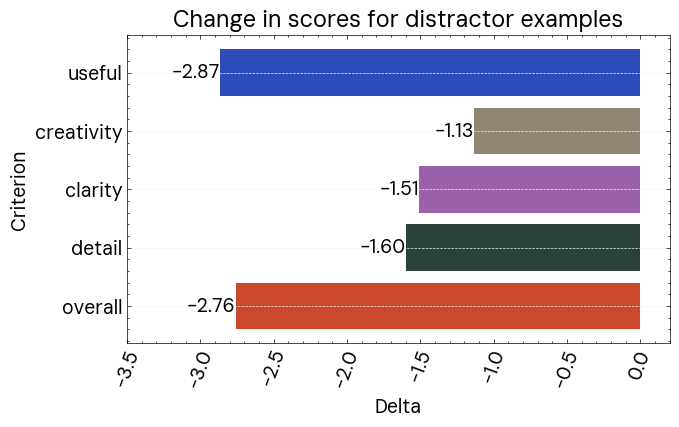

In [35]:
# Change in subjective factors for distractors

data = distractor_results['diff'][['overall'] + vibe_factors]

plt.figure()
fig, ax = plt.subplots(figsize=(7,4))

# coral_colors = ['#355146', '#CA492D', '#9B60AA','#8E8572','#2D4CB9','#80948C','#FFA18C','#E9D0EF','#D7CFC1','#8FA6F9']
coral_colors = coplot.COHERE_COLORS_ALL
plt.grid(axis='y', color='0.95', linestyle='--')
bars = ax.barh(data.index, data.values, color=[coral_colors[ix % len(coral_colors)] for ix in range(len(data))])
ax.bar_label(bars, fmt="{:0.2f}", fontsize=None)
plt.xticks(rotation = 70, fontsize=None)
plt.yticks(rotation = 0, fontsize=None)
plt.xlabel('Delta')
plt.ylabel('Criterion')
ax.set_title('Change in scores for distractor examples')

plt.xlim([-3.5,0.2])

<Figure size 350x262.5 with 0 Axes>

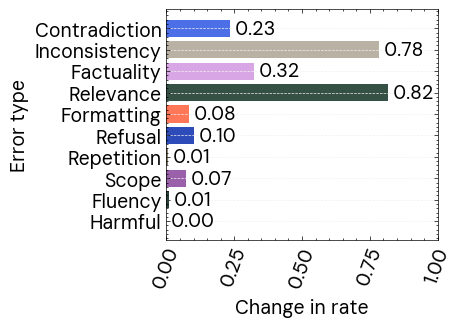

In [73]:
# Change in error rates for distractors

data = distractor_results['diff'][error_factors][::-1]

plt.figure()
fig, ax = plt.subplots(figsize=(3.5,3))

# coral_colors = ['#355146', '#CA492D', '#9B60AA','#8E8572','#2D4CB9','#80948C','#FFA18C','#E9D0EF','#D7CFC1','#8FA6F9']
coral_colors = coplot.COHERE_COLORS_ALL
plt.grid(axis='y', color='0.95', linestyle='--')
bars = ax.barh(rename_fields(data.index), data.values, color=[coral_colors[ix % len(coral_colors)] for ix in range(len(data))])
ax.bar_label(bars, fmt=" {:0.2f}", fontsize=None)
plt.xticks(rotation = 70, fontsize=None)
plt.yticks(rotation = 0, fontsize=None)
plt.xlabel('Change in rate')
plt.ylabel('Error type')
# ax.set_title('Change in error rates for distractor examples')

plt.xlim([-0.0,1])

plt.savefig('../plots/part1_distractor.pdf', bbox_inches='tight')

In [75]:
# Fit Lasso model

from sklearn import linear_model

exclude_distractors = True

y = df_unbiased[df_unbiased.sample_ix.str.startswith('distractor_') != exclude_distractors].groupby(['dataset','model','sample_ix']).score.agg(lambda x: np.mean(x))
# y = df_granular[df_granular.sample_ix.str.startswith('distractor_') != exclude_distractors].groupby(['dataset','model','sample_ix']).overall.agg(lambda x: np.mean(x))


x1 = df_granular[df_granular.sample_ix.str.startswith('distractor_') != exclude_distractors].groupby(['dataset','model','sample_ix'])[error_factors].agg(lambda x: np.mean(pd.Series.mode(x))) * -1
# x1 = df_granular[df_granular.sample_ix.str.startswith('distractor_') != exclude_distractors].groupby(['dataset','model','sample_ix'])[error_factors].agg(lambda x: np.mean(x)) * -1
x2 = df_granular[df_granular.sample_ix.str.startswith('distractor_') != exclude_distractors].groupby(['dataset','model','sample_ix'])[vibe_factors].agg(lambda x: np.mean(x)) - 3

# x = x2.merge(x1, left_index=True, right_index=True)
x = x1



regr = linear_model.Lasso(alpha=0.01)
# regr = linear_model.Ridge(alpha=10)
regr.fit(x, y)

print(regr.intercept_,  regr.score(x,y))
regr_weights = {}
for factor, coef in zip(x.columns, regr.coef_):
    print("{:}\t\t{:0.2f}".format(factor,coef))
    regr_weights[factor] = coef
    
    


(900, 10) (900,)
3.708981871827394 0.22217187942415828
contradiction		0.00
inconsistent		0.21
factuality		0.35
relevance		0.60
formatting		0.76
refusal		0.95
repetition		0.53
scope		0.00
fluency		0.00
harmful		0.00


<Figure size 350x262.5 with 0 Axes>

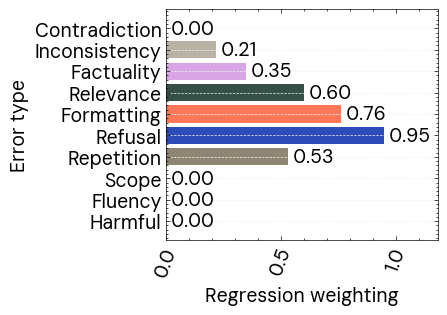

In [78]:
# Plot Lasso weights

import matplotlib.pyplot as plt

plt.figure()
fig, ax = plt.subplots(figsize=(3.5,3))

# coral_colors = ['#355146', '#CA492D', '#9B60AA','#8E8572','#2D4CB9','#80948C','#FFA18C','#E9D0EF','#D7CFC1','#8FA6F9']
coral_colors = coplot.COHERE_COLORS_ALL
plt.grid(axis='y', color='0.95', linestyle='--')
bars = ax.barh(list(rename_fields(regr_weights.keys()))[::-1], list(regr_weights.values())[::-1], color=[coral_colors[ix % len(coral_colors)] for ix in range(len(regr_weights))])
ax.bar_label(bars, fmt=" {:0.2f}")
plt.xticks(rotation = 70)
plt.yticks(rotation = 0)
plt.xlabel('Regression weighting', fontweight='bold')
plt.ylabel('Error type')
# ax.set_title(r'Lasso ($\alpha=0.01$) regression weights')

plt.xlim([-0,1.18])

plt.savefig('../plots/part1_lasso.pdf', bbox_inches='tight')

Index(['detail', 'clarity', 'creativity', 'useful'], dtype='object')
[0.79919834 0.09532332 0.07395669 0.03152166]
[[ 0.56705811  0.37714537  0.46381102  0.56664434]
 [ 0.30840022 -0.75277056  0.52934278 -0.2408776 ]
 [-0.58797209  0.32557792  0.71018148 -0.20959508]
 [-0.48746612 -0.43022886  0.01782758  0.7595802 ]]


<Figure size 350x262.5 with 0 Axes>

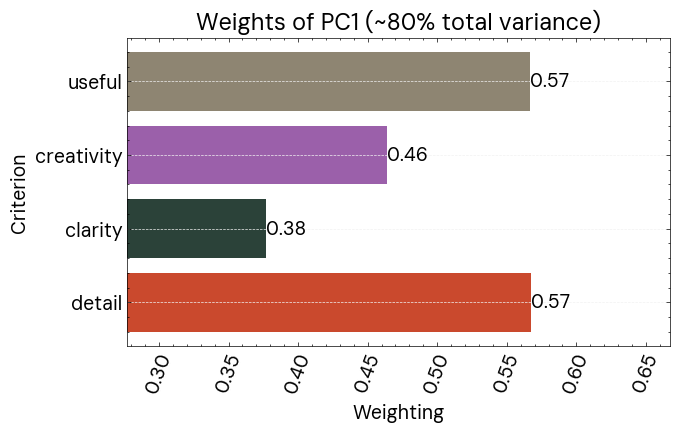

<Figure size 350x262.5 with 0 Axes>

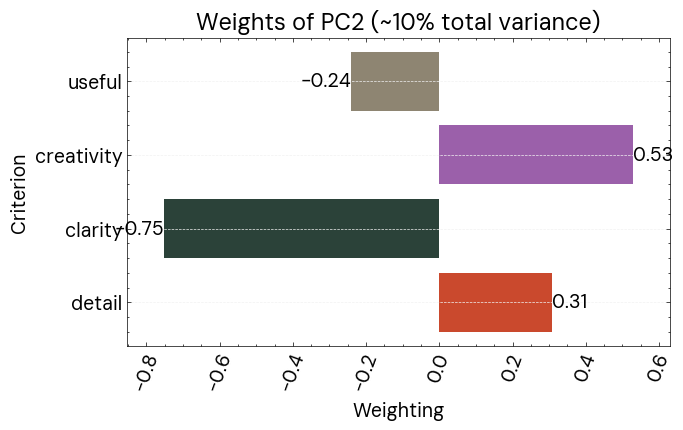

<Figure size 350x262.5 with 0 Axes>

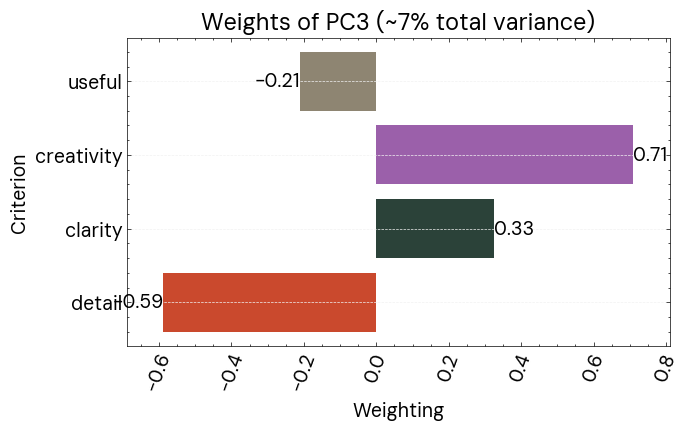

<Figure size 350x262.5 with 0 Axes>

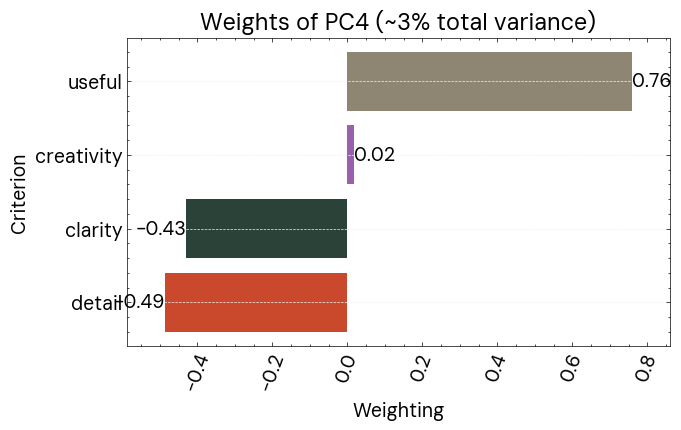

In [39]:
# PCA decomposition of subjective factors

from sklearn.decomposition import PCA

data = df_combined_filtered[vibe_factors]

print(data.columns)

pca = PCA(n_components=4)
pca.fit(data)
print(pca.explained_variance_ratio_)
print(pca.components_ * -1)



for ix, component in enumerate(pca.components_):

    plt.figure()
    fig, ax = plt.subplots(figsize=(7,4))

    # coral_colors = ['#355146', '#CA492D', '#9B60AA','#8E8572','#2D4CB9','#80948C','#FFA18C','#E9D0EF','#D7CFC1','#8FA6F9']
    coral_colors = coplot.COHERE_COLORS_ALL
    plt.grid(axis='y', color='0.95', linestyle='--')
    bars = ax.barh(data.columns, component*-1, color=[coral_colors[ix % len(coral_colors)] for ix in range(len(data))])
    ax.bar_label(bars, fmt="{:0.2f}", fontsize=None)
    plt.xticks(rotation = 70, fontsize=None)
    plt.yticks(rotation = 0, fontsize=None)
    plt.xlabel('Weighting')
    plt.ylabel('Criterion')
    ax.set_title('Weights of PC{:} (~{:0.0f}% total variance)'.format(ix+1, pca.explained_variance_ratio_[ix]*100))

    plt.xlim([-0.1+min(component*-1),0.1+max(component*-1)])
    plt.show()

In [49]:
from nltk.metrics.agreement import AnnotationTask

scores = defaultdict(list)
scores_by_sample = defaultdict(list)

for row in results:
    scores[row['input_meta']['model_a']].append(int(row['label_annotations']['overall_a']))
    scores[row['input_meta']['model_b']].append(int(row['label_annotations']['overall_b']))
    
    scores_by_sample[(row['input_meta']['dataset'],row['input_meta']['sample_ix'], row['input_meta']['model_a'])].append(int(row['label_annotations']['overall_a']))
    scores_by_sample[(row['input_meta']['dataset'],row['input_meta']['sample_ix'], row['input_meta']['model_b'])].append(int(row['label_annotations']['overall_b']))

    
for model, vals in scores.items():
    print(model, "\t{:0.2f}".format(np.mean(vals)))

refs 	3.61
command_6B_v14_20230622 	3.42
command_52B_v14_20230622 	3.56
mpt30instruct 	3.52
falcon40 	3.94
distractor 	1.41


In [57]:
# Error rates by dataset
df_granular[df_granular.sample_ix.str.startswith('distractor_') != True].groupby('dataset')[error_factors].mean()

,contradiction,inconsistent,factuality,relevance,formatting,refusal,repetition,scope,fluency,harmful
dataset,,,,,,,,,,
amazon,0.043382,0.124265,0.108824,0.077941,0.071324,0.021324,0.052206,0.038235,0.069853,0.011029
curation,0.035294,0.123529,0.145588,0.091176,0.078676,0.016912,0.021324,0.026471,0.041912,0.007353
wikihow,0.068382,0.100000,0.161029,0.136029,0.071324,0.069853,0.086029,0.047059,0.059559,0.027941


In [109]:
# How many distinct outputs?
len(df_combined_filtered)

900

In [110]:
# How many annotations?
len(df_unbiased), len(granular_results)

(4440, 3400)

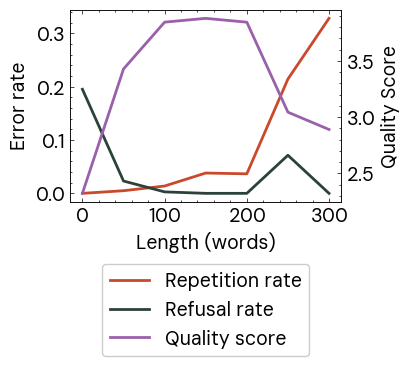

In [60]:
# Generate quality vs length plot

df_combined_filtered['length_bin'] = (df_combined_filtered['length'].clip(upper=300) / 5).round(-1) * 5

fig = plt.figure(figsize=(3.5,2.5))
ax=plt.gca()

series = []
for error_factor in ['repetition','refusal']: #,'factuality'
    line = df_combined_filtered.groupby('length_bin').mean(numeric_only=True).reset_index().plot.line('length_bin',error_factor, ax=ax, label=rename_fields([error_factor])[0]+' rate', legend=None, linewidth=2)
    series.append(line)
    
ax2 = ax.twinx()
for error_factor in ['unbiased']: #,'factuality'
    line = df_combined_filtered.groupby('length_bin').mean(numeric_only=True).reset_index().plot.line('length_bin',error_factor, ax=ax2, label=rename_fields([error_factor])[0]+' score', color=coplot.COHERE_COLORS_ALL[2], legend=None, linewidth=2)
    series.append(line)


ax.set_xlabel('Length (words)')
ax.set_ylabel('Error rate')
ax2.set_ylabel('Quality Score')
# ax.set_title('Response quality against length')

series = ax.lines + ax2.lines

plt.legend(series, [l.get_label() for l in series], loc='lower center', bbox_to_anchor=(0.5, -0.85), facecolor='white', framealpha=1, frameon=True)
# plt.legend(series, [l.get_label() for l in series], loc='center right', bbox_to_anchor=(1.85, 0.5), facecolor='white', framealpha=1, frameon=True)

plt.savefig('../plots/part1_lengthbins.pdf')

In [105]:
# Print full breakdown table

def rename_fields_latex(f):
    if f in ['annotator','gold','diff']:
#         return f.capitalize()
        return src_to_label[f]
    else:
        return rename_fields([f])[0].replace('--','-{}-')
    
data = df_combined_filtered

# data[error_factors] *= 100

print(data[error_factors+['overall','unbiased']].groupby('model').mean().rename(mapper=rename_fields_latex, axis=0).rename(mapper=rename_fields_latex, axis=1).style.format(precision=2).to_latex())
# df_combined_filtered[error_factors+['unbiased']].groupby('model').mean()


\begin{tabular}{lrrrrrrrrrrrr}
 & Contradiction & Inconsistency & Factuality & Relevance & Formatting & Refusal & Repetition & Scope & Fluency & Harmful & Quality (Biased) & Quality \\
model &  &  &  &  &  &  &  &  &  &  &  &  \\
Command 52B & 2.50 & 4.44 & 5.00 & 4.44 & 1.67 & 3.06 & 5.56 & 0.00 & 1.39 & 0.83 & 3.59 & 3.51 \\
Command 6B & 2.50 & 8.33 & 6.94 & 6.11 & 3.33 & 3.33 & 5.56 & 0.28 & 1.11 & 0.00 & 3.49 & 3.52 \\
Falcon 40B Instruct & 1.94 & 8.06 & 4.17 & 6.94 & 5.00 & 2.78 & 2.22 & 2.50 & 1.39 & 0.00 & 3.79 & 3.66 \\
MPT 30B Instruct & 0.28 & 3.06 & 5.56 & 2.22 & 1.11 & 0.28 & 0.28 & 0.28 & 0.83 & 0.00 & 3.76 & 3.77 \\
References & 0.56 & 4.72 & 8.33 & 6.11 & 1.67 & 0.00 & 0.56 & 0.28 & 0.83 & 0.56 & 3.62 & 3.50 \\
\end{tabular}

